# Geo2SigMap Tutorial: Inferencing the Model and Comparing Results with Measurements


This tutorial demonstrates the complete workflow for:
1. **Scene Generation**: Creating 2D building maps for specified PCI locations
2. **Data Preparation**: Processing real-world measurement data
3. **Model Inference**:
- 1st U-Net: Isotropic antenna pattern prediction
- 2nd U-Net: Fine-grained prediction with sparse measurements
4. **Performance Evaluation**: Quantitative comparison with ground truth (Field measurements)

**Technical Specifications**:
- Input/Output Size: 128 × 128 pixels
- Spatial Resolution: 4m/pixel

**Prequistic:**

- Make sure you have **PyTorch and scipy** installed. Check the [PyTorch website](https://pytorch.org/get-started/locally/) for more info.
- Download the pre-trained model weights and move them to `data/ml/`.
<!-- 1. Generate the scene with 2D building map for six PCI in duke campus. Where the 2D building map will be the input of our machine leading mode.
2. Load the Measurements data used in our paper, transform it's to local coordinates system and quantize it to a numpy array. Also check the `visualize_measurements.ipynb` for a better visulized measurements data.
3. Infercing the first U-Net model, the output would be a isotropic TX antena.
4. Inferencing the second u-Net mode, which can take variable number of sparse measurement point as input to geenrate a fingrade prediction.
5. Compare the 1st and 2nd U-Net with the measurement data.
 -->
<!-- 
- ML input/output size: 128 x 128 pixel
- resolution: 4m (Each pixel represent 4m x4m area in the real world) -->

In [1]:
import torch

from sklearn.metrics import mean_squared_error, mean_absolute_error,root_mean_squared_error

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
import random



from scene_generation.core import Scene
from scene_generation.utils import rect_from_point_and_size, get_utm_epsg_code_from_gps, gps_to_utm_xy, get_center_subarray
from scene_generation.empirical_pathloss_model import pathloss_38901
from scene_generation.unet.unet_model_rt import UNet

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Experimental Setup

**Focus Configuration**:
- Target PCI: A
- Measurement Device: Samsung
- Number of Sparse Samples: 200

Make sure you download the pre-trained model weights from our github repo's release page and put them under `data/ml` folder.

For detailed information about the measurement device and PCI, refer to our [paper](https://arxiv.org/pdf/2312.14303).

In [2]:
mea_device = "Samsung"
which_PCI = "A"
SS_NUM = 200
RESOLUTION = 4


scene_dir = "../../scenes/Duke_{}".format(which_PCI)

state_dict_1st_UNet = "../../data/ml/1st_checkpoint_epoch58.pth"
state_dict_2nd_UNet = "../../data/ml/2nd_checkpoint_epoch110.pth"

cell_info_dict = {
    'PCI':['A', 'B', 'C', 'D','E', 'F' ],
    'center_lat_lon':[
        (35.999186254897836, -78.9397858960648),
        (35.999186254897836, -78.9397858960648),
        (35.999186254897836, -78.9397858960648),
        (35.999186254897836, -78.9397858960648),
        (36.00307128210248, -78.93706070613855),
        (36.00307128210248, -78.93706070613855)
    ],
    'top-left_lat_lon':[
        (36.001483241320656, -78.94273733701348),
        (36.001483241320656, -78.94273733701348),
        (36.001483241320656, -78.94273733701348),
        (36.001483241320656, -78.94273733701348),
        (36.005429554748495, -78.93998431793196), 
        (36.005429554748495, -78.93998431793196), 
    ],
    'azimuth':[212, 212, 30, 30, 216, 216 ],
    'freq':[3.69e9, 3.64e9, 3.58e9, 3.56e9, 3.69e9, 3.64e9 ]


}
cell_info_df = pd.DataFrame(cell_info_dict)

<!-- ## 2. Generate the scene with 2D building map for six PCI in duke campus. Where the 2D building map will be the input of our machine leading mode.

Different from the cli tools `scenegen`, now we will dirctly using the python function api to generate the scen. Both these two methods rely on the same fucntion, the results is identitical. The python fuction provide a much flexiable way for furthere development. -->
## 1. Scene Generation


Different from the cli tools `scenegen`, now we will dirctly using the python function api to generate the scen. The python fuction provides more flexibility than the CLI tool for advanced use cases



In [3]:
polygon_points_gps = rect_from_point_and_size(
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'][0][1],
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'][0][0],
    "top-left", 
    512,
    512
)
min_lon, min_lat = polygon_points_gps[0]
max_lon, max_lat = polygon_points_gps[2]
print(
    f"Check the bbox at http://bboxfinder.com/#{min_lat:.{4}f},{min_lon:.{4}f},{max_lat:.{4}f},{max_lon:.{4}f}"
)
scene_instance = Scene()
scene_instance(
    polygon_points_gps,
    scene_dir,
    None,
    osm_server_addr="https://overpass-api.de/api/interpreter",
    lidar_calibration=False,
    generate_building_map=True
)

utm_epsg = get_utm_epsg_code_from_gps(
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'][0][1],
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'][0][0],
)


Check the bbox at http://bboxfinder.com/#35.9969,-78.9429,36.0014,-78.9371


Parsing buildings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 1095.81it/s]


Original Building Map Shape: (512, 512)
Cropped Building Map Shape:  (512, 512)


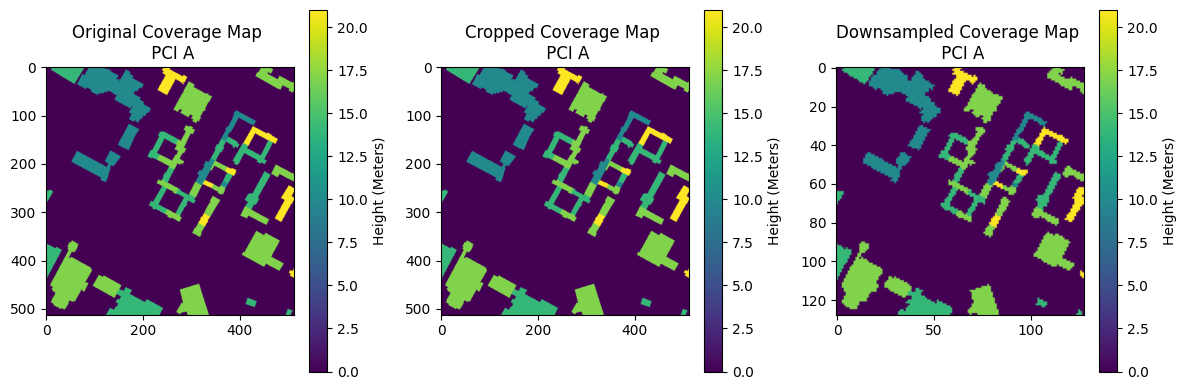

In [4]:
building_map_npy_ori = np.load("{}/2D_Building_Height_Map.npy".format(scene_dir))

print("Original Building Map Shape:", building_map_npy_ori.shape)
building_map_npy = get_center_subarray(building_map_npy_ori, 512, 512)
print("Cropped Building Map Shape: ", building_map_npy.shape)

building_map_npy_res_4 = building_map_npy[::4,::4]



# Create side-by-side plots for original, cropped, down sampled building map
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# 1) Original building map
im_ori_bmap = axes[0].imshow(building_map_npy_ori)
axes[0].set_title('Original Coverage Map \n PCI {}'.format(which_PCI))
cbar_raw = plt.colorbar(im_ori_bmap, ax=axes[0])
cbar_raw.set_label('Height (Meters)')

# 2) Cropped building map (center 512x512 subarray)
im_cropped_bmap = axes[1].imshow(building_map_npy)
axes[1].set_title('Cropped Coverage Map \n PCI {}'.format(which_PCI))
cbar_db = plt.colorbar(im_cropped_bmap, ax=axes[1])
cbar_db.set_label('Height (Meters)')

# 3) Down sampled building map
im_ds_bmap = axes[2].imshow(building_map_npy_res_4)
axes[2].set_title('Downsampled Coverage Map \n PCI {}'.format(which_PCI))
cbar_db_flip = plt.colorbar(im_ds_bmap, ax=axes[2])
cbar_db_flip.set_label('Height (Meters)')

plt.tight_layout()
plt.show()



## 2. Measurement Data Preparation


**Note:** check the `visualize_measurements.ipynb` for a better visulized measurements data.

In [5]:
measurement_data = pd.read_csv("../../data/measurements/Duke_CBRS.csv")

# Filter out the measurement data collected by specified device and for specified PCI.
measurement_data_filtered = measurement_data[(measurement_data['PCI'] == which_PCI) & (measurement_data['device'] == mea_device)]

measurement_data_filtered

,PCI,latitude,longitude,device,rsrp
203,A,35.998821,-78.940651,Samsung,-80
571,A,35.999005,-78.940536,Samsung,-88
573,A,35.998797,-78.940672,Samsung,-81
598,A,35.999466,-78.940202,Samsung,-110
600,A,35.998288,-78.939732,Samsung,-88
...,...,...,...,...,...
20348,A,35.999540,-78.940308,Samsung,-103
20349,A,35.998634,-78.943191,Samsung,-115
20351,A,35.995545,-78.943101,Samsung,-103
20352,A,35.995504,-78.939662,Samsung,-110


Total number of measurements:  1850
Total number of pixels after rasterization to 4m resolution: 550
Total number of valid pixels (No overlapping wit building):  530


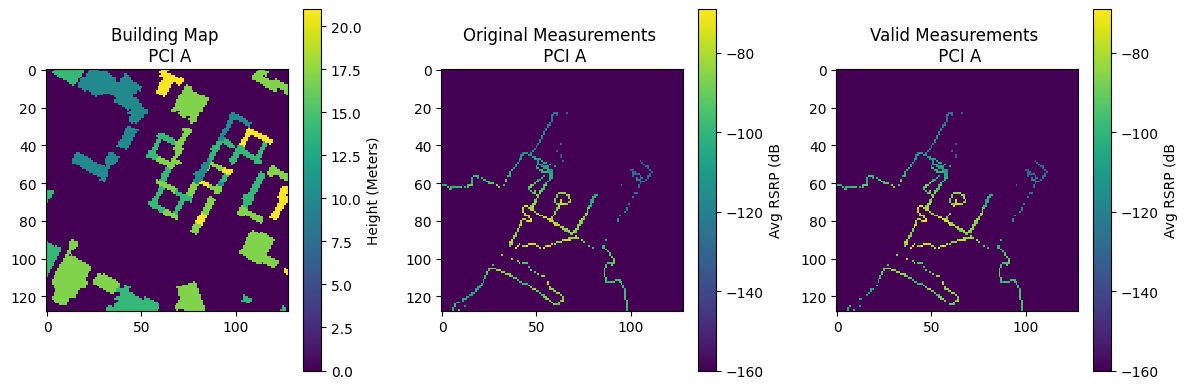

In [6]:

# generate list of tuples of (numpy_row, numpy_col, rsrp) by converting lat,lon into 
# local coordinates. 'list of tuples' is represented by np.array
measurement = np.empty([len(measurement_data_filtered["latitude"]), 3])
measurement[:, 0] = measurement_data_filtered["latitude"]
measurement[:, 1] = measurement_data_filtered["longitude"]
measurement[:, 2] = measurement_data_filtered["rsrp"]


top_left_coord_x_utm,top_left_coord_y_utm, _   = gps_to_utm_xy(
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'][0][1],
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'][0][0],
    utm_epsg)



for idx, point in enumerate(measurement):

    mea_x_utm, mea_y_utm, _ = gps_to_utm_xy(measurement[idx,1], measurement[idx,0], utm_epsg )
    row = top_left_coord_y_utm - mea_y_utm 
    col =  mea_x_utm - top_left_coord_x_utm
    
    measurement[idx, 0] = row
    measurement[idx, 1] = col





ground_truth_list = measurement




print("Total number of measurements: ", len(ground_truth_list))

ground_truth_tmp =  np.empty((128, 128), dtype=object)
count_num_no_building = 0


for point in ground_truth_list:
    row = int(point[0]/4)
    col = int(point[1]/4)
    if row >=128 or col >= 128 or row < 0 or col < 0:
        #print("{}:{}".format(row,col))
        continue
    #valid_num_mea_dic[device_name][which_PCI] = valid_num_mea_dic[device_name][which_PCI] +1
    # if building_map_npy_res_4[row,col] != 0:
    #     # row, col = col_row_for_no_building(row, col)  # attempts to update row, col 
    #     # if row is None or col is None:  # didn't find good row, col
    #     count_num_no_building += 1
    #     continue
    if ground_truth_tmp[row, col] is None:
        ground_truth_tmp[row, col] = np.array(point[2])
    else:
        ground_truth_tmp[row][col] = np.append(ground_truth_tmp[row][col], point[2])



       


ground_truth_arr = np.empty((128, 128))
for row in range(128):
    for col in range(128):
        if ground_truth_tmp[row, col] is None:
            ground_truth_arr[row][col] = -160
        else:
            # ground_truth_arr[row][col] = ground_truth_tmp[row,col].mean()
            # ground_truth_arr[row][col] = np.median(ground_truth_tmp[row,col])
            ground_truth_arr[row][col] = 10 * np.log10( ( 10 ** ( ground_truth_tmp[row,col]/ 10)  ).mean() )



# Filter out the pixels where is block by the building.
# This may due to the GPS error and/or geographical data error
condition = (ground_truth_arr != -160) & (building_map_npy_res_4 != 0)  # Identify pixels to modify


ground_truth_arr_valid = ground_truth_arr.copy()
ground_truth_arr_valid[condition] = -160  # Update values





print("Total number of pixels after rasterization to 4m resolution: {}".format(np.sum(ground_truth_arr != -160))) 
print("Total number of valid pixels (No overlapping wit building):  {}".format(np.sum(ground_truth_arr_valid != -160)))
  

# Create side-by-side plots for original, cropped, down sampled building map
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# 1) Building map
im_bmap = axes[0].imshow(building_map_npy_res_4, interpolation='none')
axes[0].set_title('Building Map \n PCI {}'.format(which_PCI))
cbar_raw = plt.colorbar(im_bmap, ax=axes[0])
cbar_raw.set_label('Height (Meters)')

# 2) TX positional map
im_ori_mea = axes[1].imshow(ground_truth_arr, interpolation='none')
axes[1].set_title('Original Measurements \n PCI {}'.format(which_PCI))
cbar_db = plt.colorbar(im_ori_mea, ax=axes[1])
cbar_db.set_label('Avg RSRP (dB')

# 3) Pathloss
im_valid_mea = axes[2].imshow(ground_truth_arr_valid, interpolation='none')
axes[2].set_title('Valid Measurements \n PCI {}'.format(which_PCI))
cbar_db_flip = plt.colorbar(im_valid_mea, ax=axes[2])
cbar_db_flip.set_label('Avg RSRP (dB')

plt.tight_layout()
plt.show()


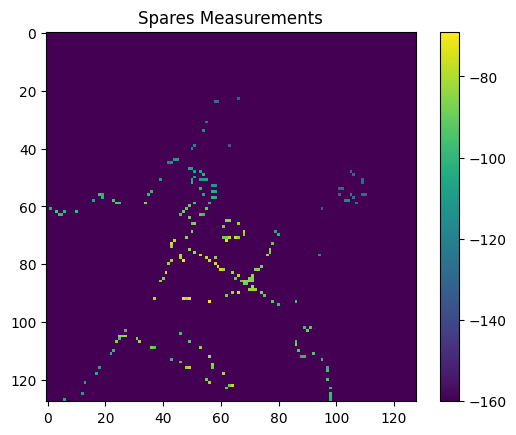

In [7]:
ss_map = np.full((128, 128), -160)


# Get valid positions (where ground_truth_arr_valid != -160)
valid_positions = np.argwhere(ground_truth_arr_valid != -160)  # Get (row, col) indices
    
# Randomly select SS_NUM positions from valid ones
selected_indices = valid_positions[np.random.choice(len(valid_positions), SS_NUM, replace=False)]

# Copy values from the original array to the ss_map at selected positions
for row, col in selected_indices:
    ss_map[row, col] = ground_truth_arr_valid[row, col]


plt.imshow(ss_map, interpolation='none')
plt.title("Spares Measurements")
plt.colorbar()
plt.show()

## 3. **Model Inference**:
- 1st U-Net: Isotropic antenna pattern prediction

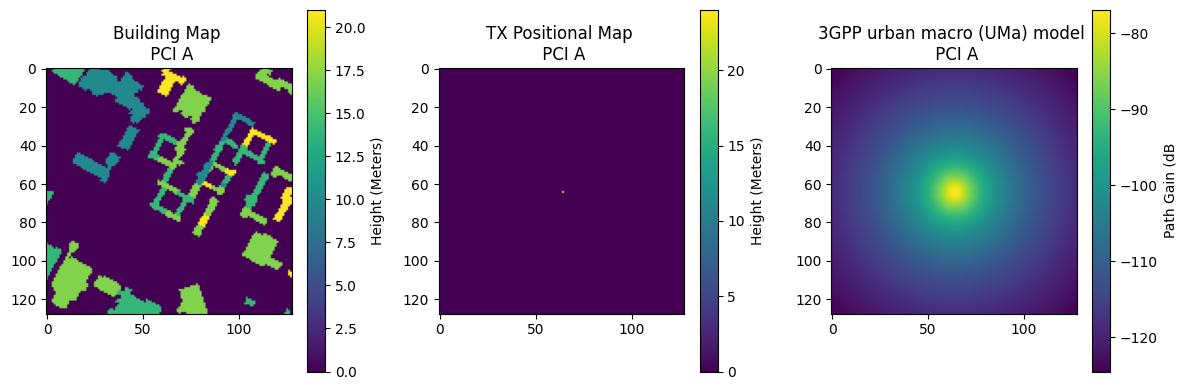

In [8]:
# Construct the TX position channel
tx_x = 256
tx_y = 256
tx_position = [tx_x // 4, tx_y // 4]
tx_height = 24
tx_position_channel = np.full((128, 128), 0, dtype=int)
# tx_height = np.max(building_height_arr)
tx_position_channel[tx_position[1]][tx_position[0]] = tx_height

distance = np.arange(0, 1450, 1)

# lookup table for path_loss_res, resolution=1 meter
path_loss_res, _ =  pathloss_38901(distance,3.64, h_bs=int(tx_height), h_ut=2)

path_loss_heat_map = np.full((128, 128), 0, dtype=float)



for row in range(path_loss_heat_map.shape[0]):
    for col in range(path_loss_heat_map.shape[1]):
        # Compute the distance between pixel and tx
        dist = math.sqrt((tx_position[1]*4 - row*4)**2 + (tx_position[0]*4 - col*4)**2)
 
        path_loss_heat_map[row][col] =  -1 * path_loss_res[int(dist)]


net_iso = UNet(n_channels=2, n_classes=1, bilinear=False, pathloss=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net_iso.to(device=device)


# 2.Load state dict
state_dict = torch.load(state_dict_1st_UNet, map_location=device)
net_iso.load_state_dict(state_dict)



# Combine all the channels together
combined_input = np.zeros((3, 128, 128), dtype=float)
combined_input[0,:, :] = np.copy(building_map_npy_res_4)
combined_input[1,:, :] = tx_position_channel
combined_input[2,:, :] = path_loss_heat_map





# Create side-by-side plots for original, cropped, down sampled building map
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# 1) Building map
im_bmap = axes[0].imshow(combined_input[0,:, :])
axes[0].set_title('Building Map \n PCI {}'.format(which_PCI))
cbar_raw = plt.colorbar(im_bmap, ax=axes[0])
cbar_raw.set_label('Height (Meters)')

# 2) TX positional map
im_tx_pos = axes[1].imshow(combined_input[1,:, :])
axes[1].set_title('TX Positional Map \n PCI {}'.format(which_PCI))
cbar_db = plt.colorbar(im_tx_pos, ax=axes[1])
cbar_db.set_label('Height (Meters)')

# 3) Pathloss
im_uma = axes[2].imshow(combined_input[2,:, :])
axes[2].set_title('3GPP urban macro (UMa) model \n PCI {}'.format(which_PCI))
cbar_db_flip = plt.colorbar(im_uma, ax=axes[2])
cbar_db_flip.set_label('Path Gain (dB')

plt.tight_layout()
plt.show()

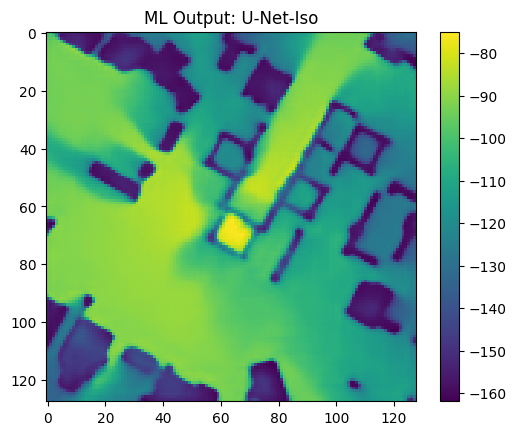

In [9]:
# Eval
images =  torch.as_tensor(combined_input.copy()).float().contiguous()


# Since we directly load the data by manual, add batch dimension to the front of data
images = images[None,:, :, :]


net_iso.eval()

images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)


with torch.no_grad():
    output = net_iso(images
                    ).squeeze().cpu()

output_iso_UNet = output.squeeze().cpu().numpy()



plt.imshow(output_iso_UNet, interpolation='none')
plt.title("ML Output: U-Net-Iso")
plt.colorbar()
plt.show()

## 3. **Model Inference**:
- 2nd U-Net: Fine-grained prediction with sparse measurements

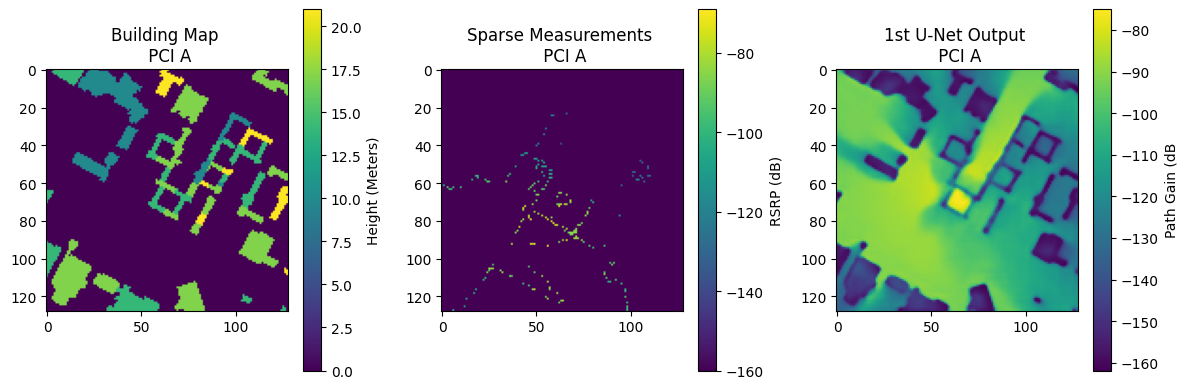

In [10]:
# 1.Create the Model
net = UNet(n_channels=3, n_classes=1, bilinear=False, pathloss=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device=device)


# 2.Load state dict
state_dict = torch.load(state_dict_2nd_UNet, map_location=device)
net.load_state_dict(state_dict)


combined_input = np.zeros((3, 128, 128), dtype=float)

# Combine all the channels together
combined_input[0,:, :] = building_map_npy_res_4

combined_input[1,:, :] = ss_map

combined_input[2,:, :] = output_iso_UNet







# Create side-by-side plots for original, cropped, down sampled building map
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# 1) Building map
im_bmap = axes[0].imshow(combined_input[0,:,:])
axes[0].set_title('Building Map \n PCI {}'.format(which_PCI))
cbar_raw = plt.colorbar(im_bmap, ax=axes[0])
cbar_raw.set_label('Height (Meters)')

# 2) Sparse Measurements
im_ss = axes[1].imshow(combined_input[1,:,:])
axes[1].set_title('Sparse Measurements \n PCI {}'.format(which_PCI))
cbar_db = plt.colorbar(im_ss, ax=axes[1])
cbar_db.set_label('RSRP (dB)')

# 3) 1st U-Net output
im_1st_output = axes[2].imshow(combined_input[2,:,:])
axes[2].set_title('1st U-Net Output \n PCI {}'.format(which_PCI))
cbar_db_flip = plt.colorbar(im_1st_output, ax=axes[2])
cbar_db_flip.set_label('Path Gain (dB')

plt.tight_layout()
plt.show()


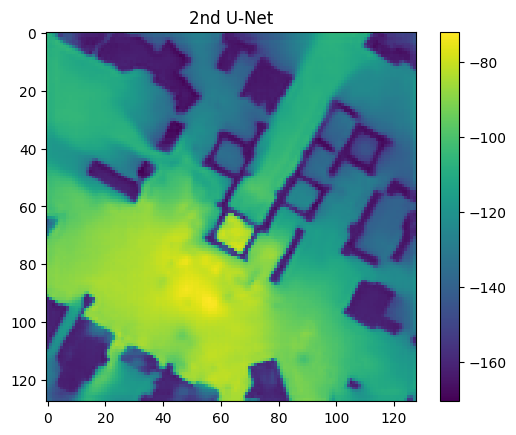

In [11]:

# 4. Eval
images = torch.as_tensor(combined_input.copy()).float().contiguous()


# Since we directly load the data by manual, add batch dimension to the front of data
images = images[None,:, :, :]

net.eval()

images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)

with torch.no_grad():
    output = net(images).cpu()
output = output.squeeze().cpu().numpy()



plt.imshow(output, interpolation='none')
plt.title("2nd U-Net")
plt.colorbar()
plt.show()

## 4. **Performance Evaluation**: Quantitative comparison with ground truth (Field measurements)


In [12]:
def evaluate_predictions(y_true, y_pred, model_name):
    """Calculate comprehensive evaluation metrics"""
    mask = y_true != -160  # Ignore invalid pixels
    
    metrics = {
        'RMSE': root_mean_squared_error(y_true[mask], y_pred[mask]),
        'MAE': mean_absolute_error(y_true[mask], y_pred[mask]),
    }
    
    print(f"\n{model_name} Performance:")
    for k, v in metrics.items():
        print(f"- {k}: {v:.2f}")
    
    return metrics

# Compare all predictions
metrics_iso = evaluate_predictions(ground_truth_arr_valid, output_iso_UNet, "1st U-Net (Isotropic)")
metrics_adaptive = evaluate_predictions(ground_truth_arr_valid, output, "2nd U-Net (Adaptive)")




1st U-Net (Isotropic) Performance:
- RMSE: 12.69
- MAE: 10.40

2nd U-Net (Adaptive) Performance:
- RMSE: 6.48
- MAE: 4.01
